# Detección de "outliers" usando *Isolation Forests*

En la lección anterior vimos cómo usar el método de *z-scores* para detección de "outliers" y vimos qué es menos robusto que el método de Tukey (también visto anteriormente), pues requiere que los datos (incluyendo los "outliers") tengan una distribución normal.

En esta lección veremos una tercera alternativa para la detección objetiva de "outliers": el uso de bosques de aislamiento o *isolation forests*.

Este método no es estadístico sino más bien heurístico, y es independiente de la distribución que tengan nuestros datos.

Así que comenzaremos viendo un ejemplo sencillo para comprender el funcionamiento de este método y luego veremos cómo usarlo para detectar "outliers" en una Serie de Tiempo. Y, al igual que en las lecciones anteriores, veremos las ventajas y desventajas de este método en comparación con las tres técnicas que vimos anteriormente.

## 1. ¿Qué son los bosques de aislamiento?

Son un algoritmo para la detección de *outliers*. La idea básica es que subdividimos iterativamente el set de datos y la idea es generar agrupaciones de datos cada vez más pequeñas hasta que cada dato esté aislado totalmente (es decir hasta tener agrupaciones de un sólo dato).

Luego la idea es cuantificar, por cada dato, cuántas particiones se requieren para lograr aislarlo totalmente (de ahí el nombre: *bosques de aislamiento*).

Lo interesante de esto es que los datos que NO son "outliers" serán más homogéneos y más difíciles de separar y, por tanto, requerirán más particiones en comparación con los "outliers".

Así, si cuantificamos el número de particiones requeridas para separar cada dato, aquellos datos con menos particiones tendrán más probabilidad de ser "outliers".

Veamos el algoritmo para entender estos detalles.

## 2. El algoritmo de bosques de aislamiento

Veamos cada uno de los pasos en este algoritmo:

0. Definir el número de particiones inicial. Cada una de estas particiones se conoce como "árbol" (de allí el nombre de "bosques de aislamiento"). En la práctica se usan 100 o más árboles, pero en este sencillo ejemplo asumiremos únicamente 2:

![](isolation-forests-paso0.png)

1. Subdividir cada árbol hasta que cada dato quede completamente aislado en una hoja. Para esto, en cada partición, se definen umbrales **aleatorios** dentro del rango de valores de cada agrupación y se subdividen los datos con base en dicho umbral:

![](isolation-forests-paso1.png)

2. Calcular la profundidad promedio de cada dato, es decir en promedio cuántas particiones se requieren para aislarlo por completo:

![](isolation-forests-paso-2.png)

3. Se normalizan las profundidades promedio para obtener lo que se conocen como los puntajes de las anomalías (*anomaly scores*). Los valores extremos tenderán a tener valores más cercanos a 1 y los datos "normales" valores cercanos a 1:

![](isolation-forests-paso-3.png)

4. Se define un umbral sobre los puntajes de las anomalías a partir del cual definiremos qué es y qué no es un "outlier". Usualmente este umbral se define como **la proporción de valores extremos esperados con respecto a la totalidad de los datos**

Así que teniendo claro cómo funciona el algoritmo, veamos un ejemplo sencillo de implementación.

## 3. *Isolation forests* con Scikit-Learn

Scikit-Learn nos permite, con muy pocas líneas de código, usar el algoritmo de bosques de aislamiento para detectar *outliers* en nuestros datos.

Para ello usamos el módulo "IsolationForest". Veamos cómo hacerlo por ejemplo para el mismo set de datos del ejemplo anterior:

In [1]:
# Crear el set de datos. Usar "reshape" para garantizar que es un vector columna
import numpy as np

X = np.array([3, 2, 5, 60, 4]).reshape(-1,1)
X

array([[ 3],
       [ 2],
       [ 5],
       [60],
       [ 4]])

El siguiente paso es crear una instancia de "IsolationForest". En este caso definiremos dos parámetros:

- `contamination = 1/5`: el umbral que usaremos al momento de la clasificación
- `n_estimators = 20`: número de árboles iniciales (por defecto Scikit-Learn usa 100)
- `random_state = 123`: como cada partición define un umbral aleatorio, al usar este parámetro obtendremos resultados reproducibles


Veamos esta parte de la implementación:

In [2]:
from sklearn.ensemble import IsolationForest

bosque = IsolationForest(contamination=1/5, n_estimators = 20, random_state=123)
bosque

IsolationForest(contamination=0.2, n_estimators=20, random_state=123)

Ahora le presentamos los datos a este bosque usando el método `fit()`. Al ejecutar esta línea de código se ejecutará precisamente el algoritmo de *isolation forests*:

In [3]:
bosque.fit(X)

IsolationForest(contamination=0.2, n_estimators=20, random_state=123)

¡Y en este punto ya se ha ejecutado el algoritmo y ya podemos usar el bosque para clasificar los datos!

Veamos por ejemplo los puntajes (*anomaly scores*) de cada dato:

In [4]:
# Calcular anomaly scores
scores = bosque.decision_function(X)

# E imprimir por cada dato su puntaje correspondiente:
for i, x in enumerate(X):
    print(x, scores[i])

[3] 0.19060758360101576
[2] 0.13147787201738015
[5] 0.05490582691251861
[60] -0.21962330765007476
[4] 0.16492767810563747


Vemos que los datos "normales" tienen puntajes positivos mientras que el "outlier" tiene un puntaje de -0.21.

Para clasificar los datos simplemente usamos el método `predict()` que tomará el umbral definido antes (parámetro "contamination") y lo aplicará a los puntajes que acabamos de imprimir en pantalla. Como resultado generará un arreglo del mismo tamaño del set de datos original pero con etiquetas 1 (normal) y -1 ("outlier"):

In [5]:
# Generar predicciones (clasificar cada dato como normal u "outlier")
preds = bosque.predict(X)

# E imprimir por cada dato su categoría
for i, x in enumerate(X):
    print(x, preds[i])

[3] 1
[2] 1
[5] 1
[60] -1
[4] 1


¡Y listo, ya tenemos un ejemplo básico de uso de los bosques de aislamiento!

Ahora sí podemos ver cómo usarlo en nuestra Serie de Tiempo.

## 4. Detección de "outliers" usando bosques de aislamiento

### 4.1. Funciones auxiliares y set de datos

Comencemos creando la función auxiliar de las lecciones anteriores y pre-procesando el set de datos.

Usaremos la misma función `graficar_outliers` de la lección anterior:

In [6]:
# Graficar outliers
import seaborn as sns
import matplotlib.pyplot as plt

def graficar_outliers(serie, fechas, outliers=None):
    '''Graficar la Serie de Tiempo y superponer "outliers" de
    referencia y detectados.
    
    Parámetros:
    - serie: la Serie de Tiempo (DataFrame de Pandas)
    - fechas: listado de fechas con los "outliers" conocidos
    - outliers: los outliers detectados (DataFrame de Pandas)'''
    
    # Graficar la Serie de tiempo
    ax = serie.plot(alpha=0.7)
    
    # Superponer outliers de referencia
    serie.loc[fechas].plot(ax=ax, style='bo')
    
    # Superponer outliers detectados (si existen)
    if outliers is not None:
        outliers.plot(ax=ax, style='rx')
        plt.legend(['Serie de Tiempo', 'Outliers conocidos', 'Outliers detectados']);
    else:
        plt.legend(['Serie de Tiempo', 'Outliers conocidos'])
    
    # Ajustar etiquetas    
    plt.xlabel('Fecha')
    plt.ylabel('# pasajeros')    

Y usaremos el mismo set de datos de las lecciones anteriores (*taxis_ny.csv*) que contiene el número de pasajeros que han hecho uso del servicio de Taxis de la ciudad de Nueva York entre el 1 de julio de 2014 y el 31 de mayo de 2015.

Los datos han sido tomados con frecuencia de 30 minutos y en total se tienen 10.320 registros:

In [7]:
# Lectura del set de datos
import pandas as pd

RUTA = '../datasets/outliers/'

taxis_df = pd.read_csv(RUTA + 'taxis_ny.csv',
                    parse_dates = ['tiempo'],
                    index_col = ['tiempo'])
taxis_df

,obs
tiempo,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820
...,...
2015-01-31 21:30:00,24670
2015-01-31 22:00:00,25721
2015-01-31 22:30:00,27309


Y creemos el listado con "outliers" conocidos:

In [8]:
# fechas con outliers conocidos
fechas =  [
        "2014-11-01",
        "2014-11-27",
        "2014-12-25",
        "2015-01-01",
        "2015-01-27"
]

Como lo vimos en la lección anterior, la detección de valores extremos funciona mejor cuando remuestreamos la Serie a una frecuencia diaria:

In [9]:
# Remuestreo a frecuencia diaria
tx_diaria = taxis_df.resample('D').mean()
tx_diaria

,obs
tiempo,
2014-07-01,15540.979167
2014-07-02,15284.166667
2014-07-03,14794.625000
2014-07-04,11511.770833
2014-07-05,11572.291667
...,...
2015-01-27,4834.541667
2015-01-28,12947.562500
2015-01-29,14686.145833


Y generemos el gráfico correspondiente (la Serie remuestreada y los valores extremos conocidos):

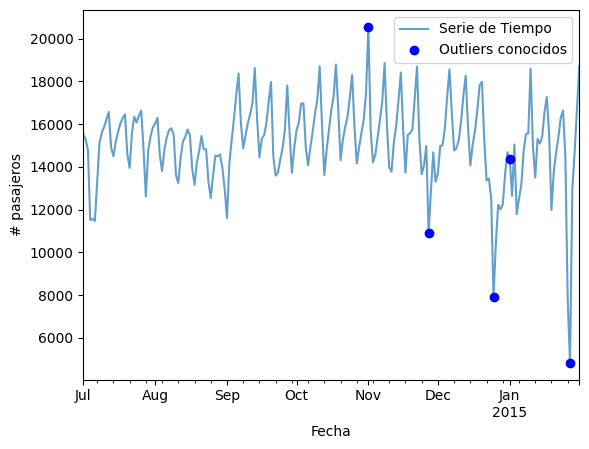

In [11]:
graficar_outliers(tx_diaria, fechas)

### 4.2. Detección de "outliers"

Y ahora creemos una función ("outliers_iforests") implementando los pasos vistos en el ejemplo anterior:

In [12]:
from sklearn.ensemble import IsolationForest

def outliers_iforests(serie, umbral=0.1):
    # Extraer arreglo NumPy correspondiente a la serie
    x = serie.to_numpy().reshape(-1,1)
    
    # Crear instancia y entrenar (usar el valor por defecto de 100 árboles)
    bosque = IsolationForest(random_state=0, contamination=umbral)
    bosque.fit(x)
    
    # Clasificar
    preds = bosque.predict(x)
    
    # Crear DataFrame
    outliers = serie[preds==-1]
    
    return outliers

¡Y listo, con esta sencilla función ya podemos detectar outliers!

Pero antes de usarla debemos estimar el número aproximado de "outliers" que tenemos en nuestros datos. Así que podemos graficar la Serie de Tiempo con los "outliers" de referencia y además imprimir en pantalla el número total de datos:

215


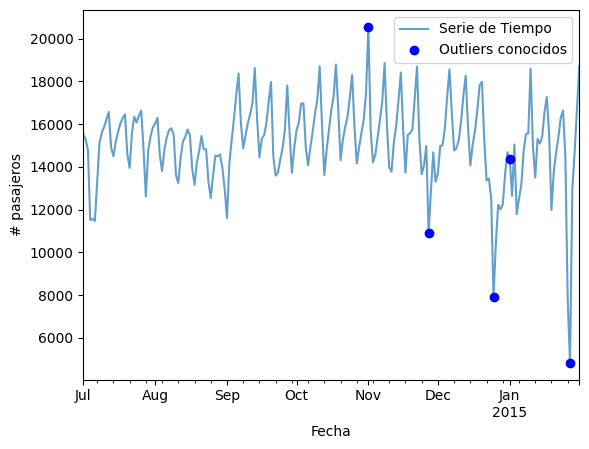

In [13]:
graficar_outliers(tx_diaria, fechas)
print(len(tx_diaria))

Y en este caso tenemos aproxidamente 5 outliers por detectar de un total de 215 datos. Esta es la proporción que debemos usar como umbral de nuestro clasificador:

                     obs
tiempo                  
2014-11-01  20553.500000
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667


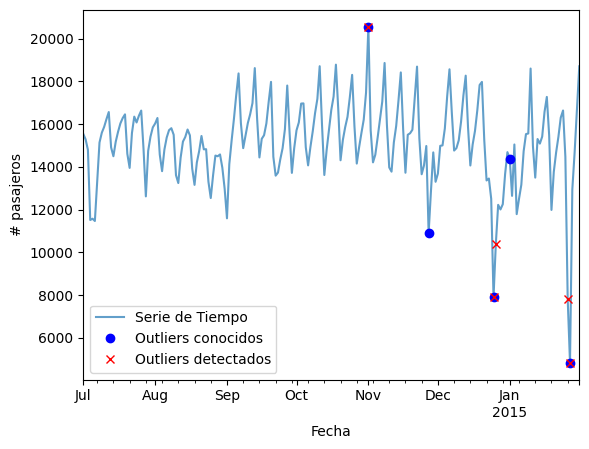

In [14]:
outliers = outliers_iforests(tx_diaria, umbral=5/215)
print(outliers)
graficar_outliers(tx_diaria, fechas, outliers)

Y en este caso hemos detectado correctamente 3 de los 5 (en realidad 4) outliers. Podríamos "jugar" un poco con el umbral para incrementar/reducir el número de "outliers" detectados.

Por ejemplo cambiemos el umbral a 7/215:

                     obs
tiempo                  
2014-11-01  20553.500000
2014-11-08  18857.333333
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667


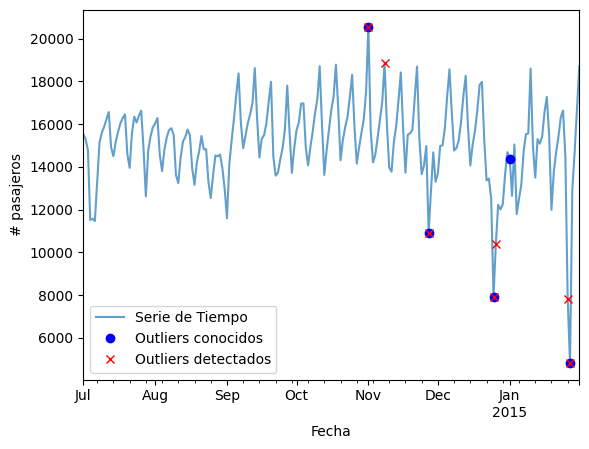

In [15]:
outliers = outliers_iforests(tx_diaria, umbral=7/215)
print(outliers)
graficar_outliers(tx_diaria, fechas, outliers)

Y vemos que esto genera un incremento en la cantidad de "outliers" detectados.

## 5. Aspectos a tener en cuenta

1. El uso de *bosques de aislamiento* no depende de la distribución de nuestros datos (como sí ocurría con los métodos de Tukey y *z-scores*)
2. Sin embargo, el nivel de exactitud en la detección de "outliers" dependerá de la definición de un umbral (y en esto se asemeja a los métodos anteriores).

En últimas tenemos 4 diferentes alternativas para la detección de "outliers": el método de inspección visual (altamente subjetivo) y 3 métodos más robustos y objetivos (Tukey, z-score y bosques de aislamiento). Ninguno de estos métodos es mejor que otro, cada uno tiene sus ventajas y limitaciones y el éxito en su uso dependerá de las características propias de la Serie de Tiempo que estemos analizando.